In [15]:
import numpy as np
import scipy.sparse
from numpy.linalg import inv, norm
import matplotlib.pyplot as plt
import seaborn as sns

def fconstant1(x):
    if 5.1 <= x[0] <= 5.6 and 3.5 <= x[1] <= 6.5:
        ux = 700
    else:
        ux = 0
    return ux

def fconstant2(x):
    if 6.1 <= x[0] <= 6.6 and 4.5 <= x[1] <= 5.5:
        ux = 300
    else:
        ux = 0
    return ux

# Global parameters
T = 1.5
D1 = 0.3
D2 = 0.3
r1 = 0.15  # Proliferation rate
r3 = 0.3  # Dying rate
sigma = 0.01
r2_macro = 0.01
r2 = r2_macro / (np.pi * (sigma ** 2))

def PDE_solve(deltat, h):
    uPrey = fconstant1
    uPred = fconstant2

    a = 10
    l = int(a / h) + 1
    m = l

    timesteps = int(T / deltat) + 1

    # Laplace Matrix with Neumann boundary conditions everywhere
    C = np.zeros((l, l))
    for i in range(l):
        for j in range(l):
            if i == j:
                C[i, j] = 4
            if abs(i - j) == 1:
                C[i, j] = -1

    C[0, 1] = -2
    C[l - 1, l - 2] = -2

    A = scipy.sparse.bmat(
        [[C if i == j else -2 * np.identity(l) if abs(i - j) == 1 and j == 0 and i == 1 else -2 * np.identity(l) if abs(i - j) == 1 and j == l - 1 else -np.identity(l) if abs(i - j) == 1 else None for i in range(m)] for j in range(m)], format='bsr').toarray()

    # Create Solution Vector (column-wise) for preys and predators
    x = np.linspace(0, a, m + 1)
    y = np.linspace(0, a, l + 1)

    U0Prey = np.zeros(int(l * m))
    a = 0
    for i in range(m):
        for j in range(l):
            U0Prey[a] = uPrey(np.array([x[i], y[j]]))
            a += 1

    U0Pred = np.zeros(int(l * m))
    a = 0
    for i in range(m):
        for j in range(l):
            U0Pred[a] = uPred(np.array([x[i], y[j]]))
            a += 1

    listU1 = [U0Prey]
    U1 = U0Prey

    listU2 = [U0Pred]
    U2 = U0Pred

    # Iteration matrices
    B1 = inv(np.identity(int(l * m)) + D1 * deltat / (h ** 2) * A)
    B2 = inv(np.identity(int(l * m)) + D2 * deltat / (h ** 2) * A)

    # Strang-Splitting with implicit Euler
    for t in range(timesteps - 1):
        U1 = U1 + deltat * 0.5 * (r1 * U1 - r2_macro * U1 * U2)  # half timestep
        U2 = U2 + deltat * 0.5 * (r2_macro * U1 * U2 - r3 * U2)
        U1 = B1.dot(U1)  # full timestep
        U2 = B2.dot(U2)
        U1 = U1 + deltat * 0.5 * (r1 * U1 - r2_macro * U1 * U2)
        U2 = U2 + deltat * 0.5 * (r2_macro * U1 * U2 - r3 * U2)

        listU1.append(U1)
        listU2.append(U2)

    return listU1, listU2

def compare_solutions(deltat1, h1, deltat2, h2):
    # Run simulations with different parameters
    listU1_1, listU2_1 = PDE_solve(deltat1, h1)
    listU1_2, listU2_2 = PDE_solve(deltat2, h2)
    
    a = 10
    l1 = int(a / h1) + 1
    l2 = int(a / h2) + 1
   
    time_steps = [0.5, 1, 1.5]
    
    # Find the corresponding time indices
    indices1 = [int(t / deltat1) for t in time_steps]
    indices2 = [int(t / deltat2) for t in time_steps]
    
    # Extract the solution vectors for the given time steps
    solutions1_1 = [listU1_1[idx] for idx in indices1]
    solutions2_1 = [listU2_1[idx] for idx in indices1]
    solutions1_2 = [listU1_2[idx] for idx in indices2]
    solutions2_2 = [listU2_2[idx] for idx in indices2]
    
    # Normalize the solutions
    solutions1_1 = [sol / np.max(sol) for sol in solutions1_1]
    solutions2_1 = [sol / np.max(sol) for sol in solutions2_1]
    solutions1_2 = [sol / np.max(sol) for sol in solutions1_2]
    solutions2_2 = [sol / np.max(sol) for sol in solutions2_2]
    
    # Reshape the solutions into matrices
    comparison = []
    # Define grid points to compare (Euclidean distance 1 to 10)
    grid_points = int(a/1)
    discr1=int(1/h1)
    discr2=int(1/h2)
    for t_idx in range(len(time_steps)):
        matrix1 = np.reshape(solutions1_1[t_idx], (int(a / h1) + 1, int(a / h1) + 1))
        matrix2 = np.reshape(solutions1_2[t_idx], (int(a / h2) + 1, int(a / h2) + 1))
        
        Solution1Discretized_t=np.zeros((grid_points, grid_points))
        FullSolution1=matrix1
        
        
        Solution2Discretized_t=np.zeros((grid_points, grid_points))
        FullSolution2=matrix2
        
        for i in range(grid_points):
            for j in range(grid_points):
                Solution1Discretized_t[i,j]=FullSolution1[i*discr1,j*discr1]
                Solution2Discretized_t[i,j]=FullSolution2[i*discr2,j*discr2]
                
        
        comparison.append(np.linalg.norm(Solution1Discretized_t-Solution2Discretized_t))

    for t_idx in range(len(time_steps)):
        matrix1 = np.reshape(solutions2_1[t_idx], (int(a / h1) + 1, int(a / h1) + 1))
        matrix2 = np.reshape(solutions2_2[t_idx], (int(a / h2) + 1, int(a / h2) + 1))
        
        Solution1Discretized_t=np.zeros((grid_points, grid_points))
        FullSolution1=matrix1
        
        
        Solution2Discretized_t=np.zeros((grid_points, grid_points))
        FullSolution2=matrix2
        
        for i in range(grid_points):
            for j in range(grid_points):
                Solution1Discretized_t[i,j]=FullSolution1[i*discr1,j*discr1]
                Solution2Discretized_t[i,j]=FullSolution2[i*discr2,j*discr2]
                
        
        comparison.append(np.linalg.norm(Solution1Discretized_t-Solution2Discretized_t))
        
    
    return np.mean(comparison)

h_values = [1, 0.5, 0.1]
def test_schemes():
    deltat_values = [0.1, 0.01,0.005, 0.0025]
    deltah_values = [1, 0.5,0.2,0.1]
    
    i=0
    j=0
    
    results_matrix = np.zeros((4, 4))
    for deltat in deltat_values:
        for deltah in deltah_values:
            #print(f"Running PDE solve with deltat={deltat1}, h={h}")
            results_matrix[3-i, j] = compare_solutions(0.001, 0.1, deltat, deltah)
            print(results_matrix[3-i, j])
            print(i,j)
            j=j+1
            
            if j==4:
                j=0
                i=i+1
    
    return results_matrix



# Run the tests
results_matrix = test_schemes()








1.222805545187755
0 0
0.38758881787179766
0 1
0.25835915816370497
0 2
0.09537788599499859
0 3
1.2484235384500504
1 0
0.3314075903557692
1 1
0.22866055574627067
1 2
0.008427568776405533
1 3
1.250630337969957
2 0
0.32852242204132986
2 1
0.2281718186686531
2 2
0.0037464080489755434
2 3
1.251769045997294
3 0
0.32709602437042773
3 1
0.2279770151051501
3 2
0.0014050440714559933
3 3


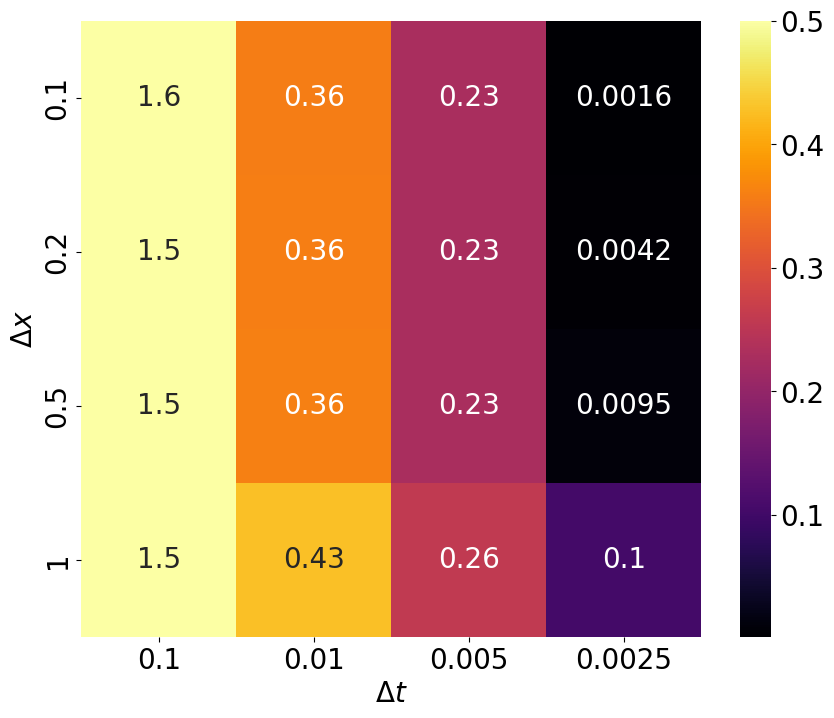

In [14]:

#%%
deltat_values = [0.1, 0.01,0.005, 0.0025]
deltah_values = [1, 0.5,0.2,0.1]
reversed_deltah_values = deltah_values[::-1]
fig = plt.figure(figsize=(10, 8))

# Create the heatmap
ax = sns.heatmap(results_matrix, annot=True, vmax=0.5, cmap="inferno", 
                 xticklabels=deltat_values, yticklabels=reversed_deltah_values, annot_kws={"size": 20})

# Increase the colorbar tick size
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)

# Set the labels and tick sizes
plt.xlabel(r'$\Delta t$', fontsize=20)
plt.ylabel(r'$\Delta x$', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig('NumericalConverenceLV.png')
